# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
import sys
import time
import copy

In [2]:
import numpy as np

In [3]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [4]:
import matplotlib.pyplot as plt

In [5]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [6]:
# dataset_name='scene'
dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)

X_train: (1812, 104) y_train: (1812, 14)


### Baselines & Skylines

In [7]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, mlp=True)

In [8]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [9]:
sampling_probas.min(axis=0)

array([0.04196816, 0.07985135, 0.07448589, 0.01369675, 0.00762209,
       0.01825114, 0.0269684 , 0.02914602, 0.00790334, 0.00671692,
       0.00631266, 0.13104026, 0.13177221, 0.00547145])

In [10]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

0 / 1812 train instances have 0 propensity


# The Experiment

In [11]:
def evaluate_model(model: Model, losses, rewards, i, j):
    losses[i,j] = model.expected_hamming_loss(X_test, y_test)
    rewards[i,j] = CRMDataset().update_from_supervised_dataset(X_test, y_test, model.predict_proba(X_test, y_test), n_samples=4).rewards.sum()

In [12]:
replay_targets = 2**np.arange(9)
replay_targets

array([  1,   2,   4,   8,  16,  32,  64, 128, 256])

In [13]:
crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(crm_model, crm_losses, crm_rewards, i, j)
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        crm_model.fit(
            crm_dataset, 
            lambda_ = .5,
            verbose = 0
        )            

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

0. . . . . . . . . 1. . . . . . . . . 2. . . . . . . . . 3. . . . . . . . . 4. . . . . . . . . 5. . . . . . . . . 6. . . . . . . . . 7. . . . . . . . . 8. . . . . . . . . 9. . . . . . . . . 

In [14]:
ucrm_losses = np.ones((10, len(replay_targets,)))
ucrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    ucrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    ucrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(ucrm_model, ucrm_losses, ucrm_rewards, i, j)
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        ucrm_dataset.update_from_supervised_dataset(X_train, y_train, .5*np.ones_like(sampling_probas), n_samples=needed_replays)
        ucrm_model.fit(
            ucrm_dataset, 
            lambda_ = .5,
            verbose = 0
        )
        
ucrm_losses = ucrm_losses.mean(axis=0)
ucrm_rewards = ucrm_rewards.mean(axis=0)

0. . . . . . . . . 

2022-11-28 09:47:50.852786: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.76 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-11-28 09:47:51.046231: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.193523472s
Constant folding an instruction is taking > 1s:

  reduce.76 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't n

1. . . . . . . . . 2. . . . . . . . . 3. . . . . . . . . 4. . . . . . . . . 5. . . . . . . . . 6. . . . . . . . . 7. . . . . . . . . 8. . . . . . . . . 9. . . . . . . . . 

In [15]:
scrm_losses = np.ones((10, len(replay_targets,)))
scrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(scrm_model, scrm_losses, scrm_rewards, i, j)
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        scrm_sampling_probas = scrm_model.predict_proba(X_train, y_train)
        scrm_dataset.update_from_supervised_dataset(X_train, y_train, scrm_sampling_probas, n_samples=needed_replays)
        scrm_model.fit(
            scrm_dataset, 
            lambda_ = -.1,
            verbose = 0
        )

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)

0. . . . . . . . . 1. . . . . . . . . 2. . . . . . . . . 3. . . . . . . . . 4. . . . . . . . . 5. . . . . . . . . 6. . . . . . . . . 7. . . . . . . . . 8. . . . . . . . . 9. . . . . . . . . 

In [16]:
mscrm_losses = np.ones((10, len(replay_targets,)))
mscrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(10):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    mscrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(mscrm_model, mscrm_losses, mscrm_rewards, i, j)
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        mscrm_sampling_probas = mscrm_model.predict_proba(X_train, y_train)
        mscrm_dataset = CRMDataset()
        mscrm_dataset.update_from_supervised_dataset(X_train, y_train, mscrm_sampling_probas, n_samples=needed_replays)
        mscrm_model.fit(
            mscrm_dataset, 
            lambda_ = .5,
            verbose = 0
        )

mscrm_losses = mscrm_losses.mean(axis=0)
mscrm_rewards = mscrm_rewards.mean(axis=0)

0. . . . . . . . . 1. . . . . . . . . 2. . . . . . . . . 3. . . . . . . . . 4. . . . . . . . . 5. . . . . . . . . 6. . . . . . . . . 7. . . . . . . . . 8. . . . . . . . . 9. . . . . . . . . 

In [17]:
baseline_rewards = []
skyline_rewards = []

baseline_reward = (1-np.logical_xor(pi0.predict(X_train), y_train)).sum() * len(X_train) / len(X_test)
skyline_reward = (1-np.logical_xor(pistar.predict(X_train), y_train)).sum() * len(X_train) / len(X_test)

current_replay = 0
for j, replay_target in enumerate(replay_targets):
    needed_replays = replay_target - current_replay
    current_replay = replay_target
    baseline_rewards += [baseline_reward * needed_replays]
    skyline_rewards += [skyline_reward * needed_replays]

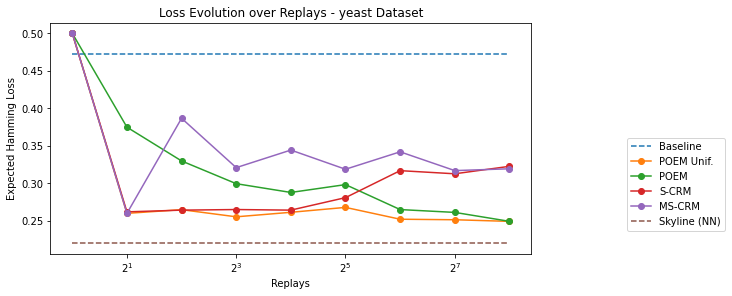

In [18]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Loss Evolution over Replays - %s Dataset' % dataset_name)
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.plot(replay_targets, .473*np.ones_like(replay_targets), '--', label='Baseline')
ax.plot(replay_targets, ucrm_losses, 'o-', label='POEM Unif.')
ax.plot(replay_targets, crm_losses, 'o-', label='POEM')
ax.plot(replay_targets, scrm_losses, 'o-', label='S-CRM')
ax.plot(replay_targets, mscrm_losses, 'o-', label='MS-CRM')
#ax.plot(replay_targets, .295*np.ones_like(replay_targets), '--', label='Skyline (LR)')
ax.plot(replay_targets, .220*np.ones_like(replay_targets), '--', label='Skyline (NN)')
ax.set_ylabel('Expected Hamming Loss')
ax.legend(loc=(1.2, .1))

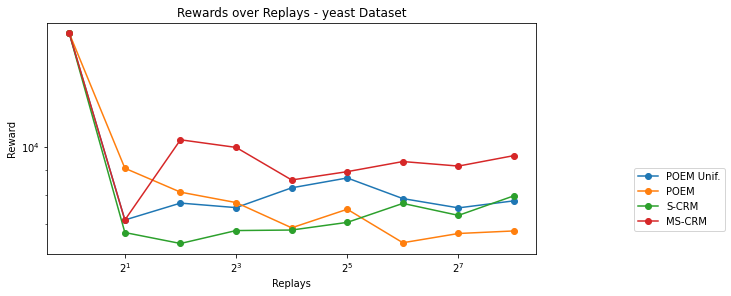

In [25]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Rewards over Replays - %s Dataset' % dataset_name)
ax.set_xlabel('Replays')
ax.set_yscale('log')
ax.set_xscale('log', base=2)
# ax.plot(replay_targets, baseline_rewards, '--', label='Baseline')
ax.plot(replay_targets, ucrm_rewards, 'o-', label='POEM Unif.')
ax.plot(replay_targets, crm_rewards, 'o-', label='POEM')
ax.plot(replay_targets, scrm_rewards, 'o-', label='S-CRM')
ax.plot(replay_targets, mscrm_rewards, 'o-', label='MS-CRM')
# ax.plot(replay_targets, skyline_rewards, '--', label='Skyline')
ax.set_ylabel('Reward')
ax.legend(loc=(1.2, .1))

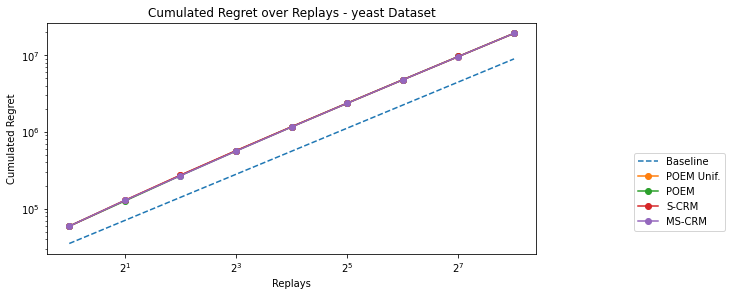

In [26]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Cumulated Regret over Replays - %s Dataset' % dataset_name)
ax.set_xlabel('Replays')
ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(baseline_rewards), '--', label='Baseline')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(ucrm_rewards), 'o-', label='POEM Unif.')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(crm_rewards), 'o-', label='POEM')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(mscrm_rewards), 'o-', label='MS-CRM')
# ax.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(skyline_rewards), '--', label='Skyline')
ax.set_ylabel('Cumulated Regret')
ax.legend(loc=(1.2, .1))